# Data and Preparation

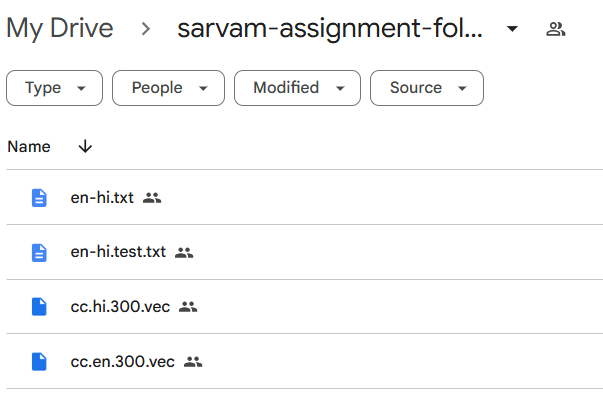

- In Google drive (My Drive) create folder 'sarvam-assignment-folder'
- Inside that folder upload files :

    en-hi.txt          ( training set ) ( file from https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.0-5000.txt )

    en-hi.test.txt     ( testing set ) ( file from https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.5000-6500.txt )

    cc.hi.300.vec        ( file from folder https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz )

    cc.en.300.vec        ( file from folder https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz )

# Code

In [25]:
!pip install numpy==1.26.4 scipy==1.13.0  # Stable versions
import numpy as np
from google.colab import drive
drive.mount('/content/drive')  # gives Google Colab access to Google Drive

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
def load_vectors(path, limit=100000):
    """
    Load word embeddings from a file and normalize the vectors.
    This function reads word embeddings from a text file where each line contains
    a word followed by its vector components. The function normalizes each vector
    to unit length.

    Parameters:
      path : str
        Path to the embedding file. The file should be in text format with
        one word and its embedding per line. The first line (header) is skipped.
      limit : int, optional
        Maximum number of embeddings to load. Default is 100,000.

    Returns:
      dict
        A dictionary mapping words to their normalized embedding vectors.
        The keys are strings (words) and the values are numpy arrays of shape (300,).

    Examples:
    en_emb = load_vectors('cc.en.300.vec')
    vector = en_emb.get('hello')
    print(vector.shape)
    (300,)
    """
    emb = {}
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        next(f)  # Skip header
        for i, line in enumerate(f):
            if i >= limit: break
            parts = line.strip().split()
            vec = np.array([float(x) for x in parts[1:301]], dtype=np.float32)
            emb[parts[0]] = vec / np.linalg.norm(vec)  # Normalization
    return emb

en_emb = load_vectors('/content/drive/MyDrive/sarvam-assignment-folder/cc.en.300.vec')
hi_emb = load_vectors('/content/drive/MyDrive/sarvam-assignment-folder/cc.hi.300.vec')


In [27]:
def load_dict(path):
    """
    Load a dictionary file into a list of word pairs.
    This function reads a text file where each line contains a word pair (typically for
    translation purposes), and returns a list of these pairs. Only lines with exactly
    two words/tokens are included.

    Parameters:
      path : str
        The file path to the dictionary file.

    Returns:
      list
        A list of word pairs, where each pair is represented as a list of two strings.
        Only lines containing exactly two space-separated tokens are included.

    Example:
    If the file contains:
        hello नमस्ते
        world संसार
        good morning शुभ प्रभात
    Then load_dict will return:
        [['hello', 'नमस्ते'], ['world', 'संसार']]
    """
    return [line.strip().split() for line in open(path) if len(line.strip().split()) == 2]

train_pairs = load_dict('/content/drive/MyDrive/sarvam-assignment-folder/en-hi.txt')
test_pairs = load_dict('/content/drive/MyDrive/sarvam-assignment-folder/en-hi.test.txt')


In [28]:

def procrustes_align(pairs):
    """
    Perform a Procrustes alignment between two sets of word embeddings.

    This function takes pairs of corresponding words from two languages and computes
    an orthogonal transformation matrix that aligns the two embedding spaces while
    preserving distances between points. The function centers the embeddings,
    computes the covariance matrix, and uses Singular Value Decomposition (SVD) to
    find the optimal orthogonal transformation.

    Parameters:
      pairs : list of tuples
        List of word pairs (source_word, target_word) to use for alignment.
        Only pairs where both words exist in their respective embedding dictionaries
        are used for the computation.

    Returns:
      numpy.ndarray
        An orthogonal transformation matrix W that can be used to map vectors from
        the source embedding space to the target embedding space.

    Notes:
      - The function assumes that global variables `en_emb` and `hi_emb` are already
        defined and contain the word embeddings for the source and target languages.
      - The covariance matrix is computed as X_centered.T @ Y_centered to ensure proper
        alignment between the two spaces.

    Examples:
    W = procrustes_align(train_pairs)
    aligned_vector = source_vector @ W
    """
    valid_pairs = [(s, t) for s, t in pairs if s in en_emb and t in hi_emb]
    X = np.array([en_emb[s] for s, t in valid_pairs])
    Y = np.array([hi_emb[t] for s, t in valid_pairs])

    # Center embeddings
    X_centered = X - np.mean(X, axis=0)
    Y_centered = Y - np.mean(Y, axis=0)

    # Compute covariance matrix (THIS WAS THE ERROR)
    cov = X_centered.T @ Y_centered  # Fixed from Y_centered.T @ X_centered

    # Perform SVD
    U, _, Vt = np.linalg.svd(cov, full_matrices=False)
    return U @ Vt

# Recompute alignment matrix
W = procrustes_align(train_pairs)


In [29]:
#  Orthogonality check
print("Orthogonality check:\n", np.round(W.T @ W, 2)[:5, :5])

#  Sample alignment
aligned_hello = en_emb['hello'] @ W
hi_sims = {word: np.dot(aligned_hello, vec) for word, vec in hi_emb.items()}
top_word = max(hi_sims, key=hi_sims.get)
print(f"\n'Aligned 'hello' → {top_word}' (sim: {hi_sims[top_word]:.2f})")


hi_matrix = np.array(list(hi_emb.values()))
hi_words = list(hi_emb.keys())
W = procrustes_align(train_pairs)

Orthogonality check:
 [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1. -0.]
 [ 0.  0.  0. -0.  1.]]

'Aligned 'hello' → हलो' (sim: 0.39)


In [30]:

def evaluate_topk(W, test_pairs, k=1):
    """
    Evaluate word alignment accuracy using Precision@k metric with proper error handling.
    This function measures how well a transformation matrix W aligns words across two
    languages by calculating the proportion of test word pairs where the transformed
    source word has its correct target translation within its top-k nearest neighbors.

    Parameters:
      W : numpy.ndarray
        Transformation matrix that maps source language embeddings to target language space.
        Should have shape compatible with source embedding dimensionality.
      test_pairs : list
        List of tuples where each tuple contains (source_word, target_word) pairs
        to evaluate the alignment on.
      k : int, optional
        Number of top predictions to consider. Default is 1 (exact match).

    Returns:
      float
        Precision@k score - the proportion of valid test pairs where the correct
        target word appears in the top-k predictions. Returns 0 if no valid pairs.

    Examples:
    W = learn_transformation(en_train_vecs, hi_train_vecs)
    accuracy = evaluate_topk(W, test_pairs, k=5)
    print(f"Precision@5: {accuracy:.4f}")
    0.7823
    """
    correct = 0
    total = 0  # Track valid pairs
    hi_words = list(hi_emb.keys())
    hi_matrix = np.array(list(hi_emb.values()))

    for s, t in test_pairs:
        # Skip invalid pairs
        if s not in en_emb or t not in hi_emb:
            continue

        total += 1
        aligned = en_emb[s] @ W
        scores = hi_matrix @ aligned

        # Get top k predictions
        top_indices = np.argsort(scores)[-k:][::-1]
        top_words = [hi_words[idx] for idx in top_indices]

        if t in top_words:
            correct += 1

    return correct / total if total > 0 else 0  # Prevent division by zero

print("=== Evaluation Metrics ===")
p1 = evaluate_topk(W, test_pairs, k=1)
p5 = evaluate_topk(W, test_pairs, k=5)
print(f"Precision@1: {p1:.4f}")
print(f"Precision@5: {p5:.4f}")




=== Evaluation Metrics ===
Precision@1: 0.2762
Precision@5: 0.5369


In [31]:
#  Ablation study with both metrics
print("\n=== Comprehensive Ablation Study ===")
sizes = [5000, 7500, 10000, 15000, 20000]
results = []

for size in sizes:
    subset = train_pairs[:size]
    W_sub = procrustes_align(subset)

    p1 = evaluate_topk(W_sub, test_pairs, k=1)
    p5 = evaluate_topk(W_sub, test_pairs, k=5)

    results.append((size, p1, p5))
    print(f"Lexicon {size}:")
    print(f"  Precision@1: {p1:.4f}")
    print(f"  Precision@5: {p5:.4f}\n")




=== Comprehensive Ablation Study ===
Lexicon 5000:
  Precision@1: 0.2500
  Precision@5: 0.4969

Lexicon 7500:
  Precision@1: 0.2750
  Precision@5: 0.5294

Lexicon 10000:
  Precision@1: 0.2762
  Precision@5: 0.5369

Lexicon 15000:
  Precision@1: 0.2762
  Precision@5: 0.5369

Lexicon 20000:
  Precision@1: 0.2762
  Precision@5: 0.5369



In [32]:
#  Systematic word translation evaluation
print("\n=== Word Translation Analysis ===")
test_words = [
    ("hello", "नमस्ते"), ("water", "पानी"), ("king", "राजा"),
    ("woman", "महिला"), ("book", "किताब"), ("computer", "कंप्यूटर")
]

for en, hi in test_words:
    if en in en_emb and hi in hi_emb:
        aligned = en_emb[en] @ W
        sim = np.dot(aligned, hi_emb[hi])

        # Get top 5 translations
        hi_scores = hi_matrix @ aligned
        top_indices = np.argsort(hi_scores)[-5:][::-1]
        top_words = [(hi_words[i], hi_scores[i]) for i in top_indices]

        print(f"\n{en} → {hi} (expected)")
        print(f"Cosine Similarity: {sim:.4f}")
        print("Top 5 predictions:")
        for i, (word, score) in enumerate(top_words, 1):
            print(f"{i}. {word}: {score:.4f}")


=== Word Translation Analysis ===

hello → नमस्ते (expected)
Cosine Similarity: 0.3501
Top 5 predictions:
1. हलो: 0.3864
2. hello: 0.3828
3. mam: 0.3694
4. wow: 0.3677
5. मैम: 0.3656

water → पानी (expected)
Cosine Similarity: 0.7257
Top 5 predictions:
1. पानी: 0.7257
2. जल: 0.5187
3. कुएं: 0.4503
4. सोतों: 0.4500
5. चापाकल: 0.4465

king → राजा (expected)
Cosine Similarity: 0.5991
Top 5 predictions:
1. राजा: 0.5991
2. राजकुमार: 0.4190
3. दरबार: 0.4129
4. वजीर: 0.3977
5. शाहजादा: 0.3977

woman → महिला (expected)
Cosine Similarity: 0.6038
Top 5 predictions:
1. औरत: 0.6433
2. महिला: 0.6038
3. स्त्री: 0.5609
4. लड़की: 0.5516
5. पुरुष: 0.5330

book → किताब (expected)
Cosine Similarity: 0.6649
Top 5 predictions:
1. किताब: 0.6649
2. पुस्तक: 0.6378
3. किताबें: 0.4940
4. किताबों: 0.4813
5. किताबो: 0.4764

computer → कंप्यूटर (expected)
Cosine Similarity: 0.7197
Top 5 predictions:
1. कंप्यूटर: 0.7197
2. कम्प्यूटर: 0.6171
3. कम्पयूटर: 0.5345
4. संगणक: 0.5226
5. कम्‍प्‍यूटर: 0.4949


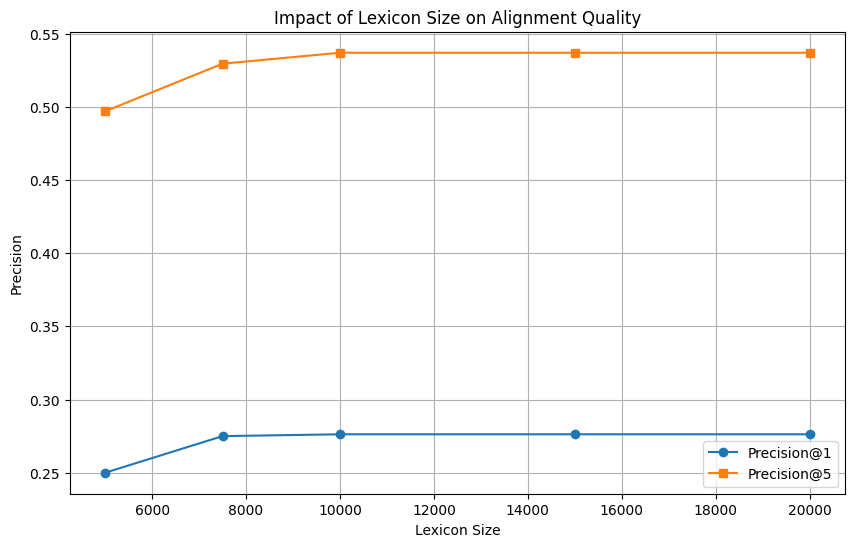

In [33]:


# Visualize the ablation study results
import matplotlib.pyplot as plt

sizes, p1_scores, p5_scores = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(sizes, p1_scores, 'o-', label='Precision@1')
plt.plot(sizes, p5_scores, 's-', label='Precision@5')
plt.xlabel('Lexicon Size')
plt.ylabel('Precision')
plt.title('Impact of Lexicon Size on Alignment Quality')
plt.legend()
plt.grid(True)
plt.savefig('ablation_study.png')
plt.show()


In [34]:
# More systematic evaluation of word translations
print("\n=== Sample Word Translations ===")
test_words = [
    ("hello", "नमस्ते"),
    ("water", "पानी"),
    ("king", "राजा"),
    ("food", "खाना"),
    ("city", "शहर"),
    ("computer", "कंप्यूटर"),
    ("friend", "मित्र"),
    ("family", "परिवार")
]

for en, hi in test_words:
    if en in en_emb and hi in hi_emb:
        aligned = en_emb[en] @ W
        sim = np.dot(aligned, hi_emb[hi])

        # Get top 5 translations
        hi_scores = {word: np.dot(aligned, vec) for word, vec in hi_emb.items()}
        top_translations = sorted(hi_scores.items(), key=lambda x: x[1], reverse=True)[:5]

        print(f"\n{en} → {hi} (expected)")
        print(f"Similarity score: {sim:.4f}")
        print("Top 5 translations:")
        for i, (word, score) in enumerate(top_translations, 1):
            print(f"  {i}. {word}: {score:.4f}")



=== Sample Word Translations ===

hello → नमस्ते (expected)
Similarity score: 0.3501
Top 5 translations:
  1. हलो: 0.3864
  2. hello: 0.3828
  3. mam: 0.3694
  4. wow: 0.3677
  5. मैम: 0.3656

water → पानी (expected)
Similarity score: 0.7257
Top 5 translations:
  1. पानी: 0.7257
  2. जल: 0.5187
  3. कुएं: 0.4503
  4. सोतों: 0.4500
  5. चापाकल: 0.4465

king → राजा (expected)
Similarity score: 0.5991
Top 5 translations:
  1. राजा: 0.5991
  2. राजकुमार: 0.4190
  3. दरबार: 0.4129
  4. वजीर: 0.3977
  5. शाहजादा: 0.3977

food → खाना (expected)
Similarity score: 0.5565
Top 5 translations:
  1. भोजन: 0.6144
  2. खाना: 0.5565
  3. खाने: 0.5229
  4. खाद्य: 0.4919
  5. भरपेट: 0.4550

city → शहर (expected)
Similarity score: 0.6905
Top 5 translations:
  1. शहर: 0.6905
  2. नगर: 0.6271
  3. महानगर: 0.5310
  4. राजधानी: 0.5190
  5. इलाके: 0.4746

computer → कंप्यूटर (expected)
Similarity score: 0.7197
Top 5 translations:
  1. कंप्यूटर: 0.7197
  2. कम्प्यूटर: 0.6171
  3. कम्पयूटर: 0.5345
  4. संगणक: 